# MVA DM 2

Pierre-Louis Guhur

# I. Algorithm K-Means

## I. 1. Loading utils functions

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time
from scipy import stats

def generate_blobs(n_samples, n_clusters=2, variance=0, distance=5):
    mu = np.random.rand(n_clusters, 2)*n_clusters*distance
    var = np.eye(2) + np.random.randn(n_clusters, 2, 2)*variance
    x = np.zeros((n_samples, 2))
    y = np.zeros(n_samples)
    bins = n_samples//n_clusters
    for i in range(n_clusters):
        start = i*bins
        end = (i+1)*bins if i + 1 != n_clusters else n_samples
        data = var[i, ...].dot(np.random.randn(2, bins)) + mu[i, :].reshape(2,1)
        x[start:end, :] = data.T
        y[start:end] = i
    return [x, y]


def plot_clusters(X, Y, K):
    for k in range(K):            
        plt.plot(X[Y == k,0], X[Y == k,1], ".")
        
def plot_centroids(centroids):
    for i in range(len(centroids)):
        plt.plot(centroids[i,0], centroids[i,1], "k*")
            
def compute_distortion(X, Y, centroids):
    distortion = 0
    for k in range(len(X)):
        diff = X[k] - centroids[Y[k]]
        distortion += diff.dot(diff)
    return distortion/2
    
def initialization_plus_plus(X, K):
    N, P = X.shape
    centroids = np.zeros((K, P))
    centroids[0, :] = X[np.random.choice(len(X))]
    for k in range(1, K):
        dist = np.zeros((N, k))
        for kk in range(k):
            diff = X - np.tile(centroids[kk,:], (N, 1))
            L2 = np.sum(diff*diff, axis=1)
            dist[:,kk] = np.sum(diff*diff, axis=1)
        pk = np.min(dist, axis=1)
        pk /= np.sum(pk)
        centroids[k, :] = X[stats.rv_discrete(values=(range(N), pk)).rvs(), :]
    return centroids

def kmeans_fit(X, centroids):
    N, P = X.shape
    K, _ = centroids.shape
    dist = np.zeros((N, K))
    for k in range(K):
        diff = X - np.tile(centroids[k,:], (N, 1))
        dist[:, k] = np.sum(diff*diff, axis=1)
    Ynew = np.argmin(dist, axis=1)
    return Ynew

def plot_kmeans(X, Y, K, centroids, n=-1):
    plt.axis('equal')
    plot_clusters(X, Y, K)
    plot_centroids(centroids)
    plt.grid()
    plt.draw()
    if n > -1:
        plt.title(f"K-means at step {n}, distortion {compute_distortion(X, Y, centroids):.2f}")
    time.sleep(0.1)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)


def kmeans(X, K, vis="all", plusplus=True, max_iter=20):
    N, P = X.shape
    Yold = np.zeros(N)
    Ynew = np.ones(N)
    
    # step 0 : initialisation
    if plusplus:
        centroids = initialization_plus_plus(X, K)
    else:
        Xc = X.copy()
        np.random.shuffle(Xc)
        centroids = Xc[:4, :]
        
    n = 0
    while (Ynew - Yold).any() != 0 and n < max_iter: 
        n += 1
        Yold = Ynew.copy()
        
        # step 1: update distance to centroid
        Ynew = kmeans_fit(X, centroids)

        # step 2: update clusters
        for k in range(K):
            centroids[k, :] = np.mean(X[Ynew == k, :], axis=0)

        # plotting
        if vis == "all":
            plot_kmeans(X, Ynew, K, centroids, n)
            
    return Ynew, centroids

## I. 2. Example of K-Means

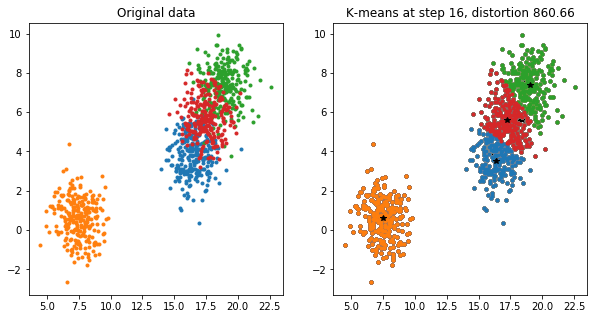

In [64]:
K = 4
N = 1000
X,Y = generate_blobs(N, K)

plt.figure(figsize=(10,5))

plt.subplot(121)
plot_clusters(X, Y, K)
plt.title("Original data")

ax = plt.subplot(122)
Yrec, centroids = kmeans(X, K, vis="all", max_iter=20, plusplus=True, ax=ax)

plt.show()

## I. 3. Comparing with and without ++ initialization

In [14]:
from IPython.display import HTML, display
import tabulate

scoring = lambda Y, Yrec: np.sum(Y[Y==Yrec])
# X, Y = generate_blobs(N, K, distance=3)
N = 1000
niter = 1000
scores = np.zeros((niter, 2))
distortion = np.zeros((niter, 2))
for i in range(niter):
    Yclassic, centr_classic = kmeans(X, K, vis="never", max_iter=1000, plusplus=False)
    scores[i, 0] = scoring(Y, Yclassic)
    distortion[i, 0] = compute_distortion(X, Yclassic, centr_classic)
    Ypp, centr_pp = kmeans(X, K, vis="never", max_iter=1000, plusplus=True)
    scores[i, 1] = scoring(Y, Ypp)
    distortion[i, 1] = compute_distortion(X, Ypp, centr_pp)


table = [["", "Mean", "Std", "Max"],
         ["Kmeans",np.mean(distortion[:,0]), np.std(distortion[:,0]),  np.max(distortion[:,0])],
         ["Kmeans++",np.mean(distortion[:,1]), np.std(distortion[:,1]),  np.max(distortion[:,1])]]

content = "<table><tr><th>Algorithm</th><th></th><th>Distortion</th><th></th></tr><tr>"
for t in table[0]:
    content += f"<th>{t}</th>"
content += "</tr>"
for r in table[1:]:
    content += f"<tr><td>{r[0]}</td>"
    for t in r[1:]:
        content += f"<td>{float(t):.2f}</td>"
    content += "</tr>"
content += "</table>"
display(HTML(content))

/Users/pierre-louis/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pierre-louis/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Algorithm,,Distortion,
,Mean,Std,Max
Kmeans,3285.06,4193.60,36655.67
Kmeans++,1330.27,704.12,12448.76


# II. Expectation Maximisation for Gaussian mixtures

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time
from scipy import stats
from numpy.linalg import inv, det
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from numpy import cos, sin, arctan
from scipy.stats import multivariate_normal as mvn


data = np.genfromtxt("./classification_data_HWK2/EMGaussian.data")
test = np.genfromtxt("./classification_data_HWK2/EMGaussian.test")
K = 4

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def plot_ellipse(mu, var, ax, alpha=0.3, color=None):
    # https://stackoverflow.com/a/25022642/4986615
    if color is None:
        color = (0.1, 0.2, 0.5)#np.random.random(3)
    vals, vecs = eigsorted(var)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    n_std = 3
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mu, width=width, height=height, angle=theta, color=color)
    ell.set_alpha(alpha=alpha)
    ax.add_artist(ell)

def plot_em(X, pi, mu, var, colors, n=-1):
    K = len(pi)
    N, P = X.shape
    plt.cla()
    ax = plt.gca()
    plt.axis('equal')
    pzx = _em_expectation(X, pi, mu, var)
    c = pzx.T.dot(colors[:K])
    for i in range(N):
        plt.plot(X[i,0], X[i,1], ".", color=c[i])
    for k in range(K):
        plt.plot(mu[k,0], mu[k,1], "k*")
        plot_ellipse(mu[k], var[k], ax,alpha=0.3, color=colors[k])
    plt.grid()
    plt.draw()
    if n > 0:
        plt.title(f"EM at step {n}")
    time.sleep(0.1)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
def em_fit(X, *params):
    pzx = _em_expectation(X, *params)
    Y = np.argmax(pzx, axis=0)
    return Y


def complete_likelihood(X, pi, mu, var):
    q = _em_expectation(X, pi, mu, var)
    return np.sum(np.log(q))

def _em_expectation(X, pi, mu, var):
    N, P = X.shape
    K = len(pi)
    q = np.zeros((K, N))
    for k in range(K):
        for n in range(N):
            gdist = mvn.pdf(X[n], mu[k], var[k])
            q[k, n] = pi[k]*gdist
    acc = np.sum(q, axis=0)
    for k in range(K):    
        q[k, :] /= acc
    return q


def _em_maximisation(X, K, q, isotropic=False):
    N, P = X.shape
    mu = np.zeros((K, P))
    var = np.zeros((K, P, P))
    pi = np.zeros(K)
    sum_q = np.sum(q, axis=1)
    
    for k in range(K):
        mu[k] = np.average(X, axis=0, weights=q[k])
        pi[k] = np.mean(q[k])
        if isotropic:
            norm = np.diag((X-mu[k]).dot((X-mu[k]).T))
            v = np.sum(q[k]*norm)/(P*np.sum(q[k])) 
            var[k, ...] = v * np.eye(P)
        else:
            sk = np.zeros((P, P))
            for i in range(N):
                diff = X[i] - mu[k]
                sk += diff.reshape(P,1).dot(diff.reshape(1,P))*q[k,i]
            var[k, ...] = sk/sum_q[k]
    return pi, mu, var
    

def _estimate_params(X, Y, K):
    N, P = X.shape
    mu = np.zeros((K, P))
    Yold = np.zeros(N)
    var = np.zeros((K, P, P))
    pi = np.zeros(K)
    for k in range(K):
        Xk = X[Y == k]
        Nk = len(Xk)
        pi[k] = Nk/N
        mu[k, :] = np.mean(Xk, axis=0)
        var[k, ...] = np.cov(Xk.T)
    return pi, mu, var


def em_train(X, K, vis="all", max_iter=100, isotropic=False):
    N, P = X.shape
    Yold = np.zeros(N)
    colors = np.array([(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.5, 0.5, 0.5)], dtype=float)
    llikehood = []
    
    # initialisation
    Y, _ = kmeans(X, K, vis="none", max_iter=100, plusplus=True)
    pi, mu, var = _estimate_params(X, Y, K)
    
    n = 0
    while (Y - Yold).any() != 0 and n < max_iter: 
        n += 1
        Yold = Y.copy()
        
        # expectation
        q = _em_expectation(X, pi, mu, var)
        
        # maximization
        pi, mu, var = _em_maximisation(X, K, q, isotropic=isotropic)
                 
        # clustering
        Y = em_fit(X, pi, mu, var)
        
        # plotting
        if vis == "all":
            plot_em(X, pi, mu, var, colors, n)
        
        # likelihood
        llikehood.append(complete_likelihood(X, pi, mu, var))
        
    return pi, mu, var, llikehood

## II. 1. When the covariance matrices are proportional to the identity.

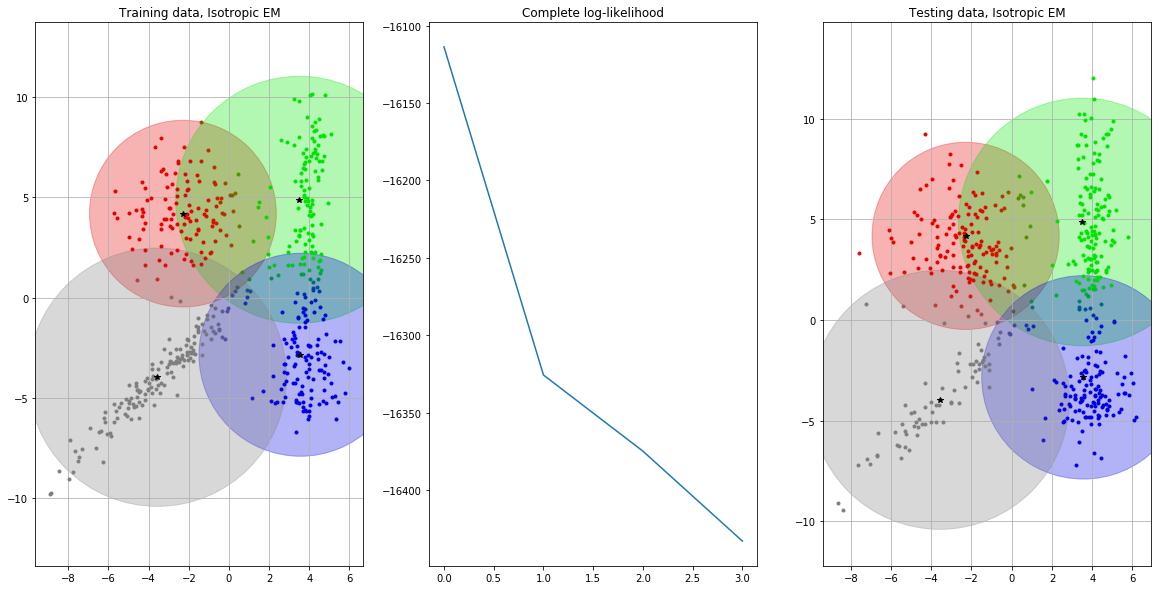

In [27]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
pi, mu, var, llc = em_train(data, K, vis="all", max_iter=50, isotropic=True)
plt.title("Training data, Isotropic EM")

plt.subplot(132)
plt.plot(llc)
plt.title("Complete log-likelihood")

plt.subplot(133)
Ytest = em_fit(test, pi, mu, var)
colors = np.array([(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.5, 0.5, 0.5)], dtype=float)
plot_em(test, pi, mu, var, colors)
plt.title("Testing data, Isotropic EM")
plt.show()

## II. 2. When the variance is a matrix  

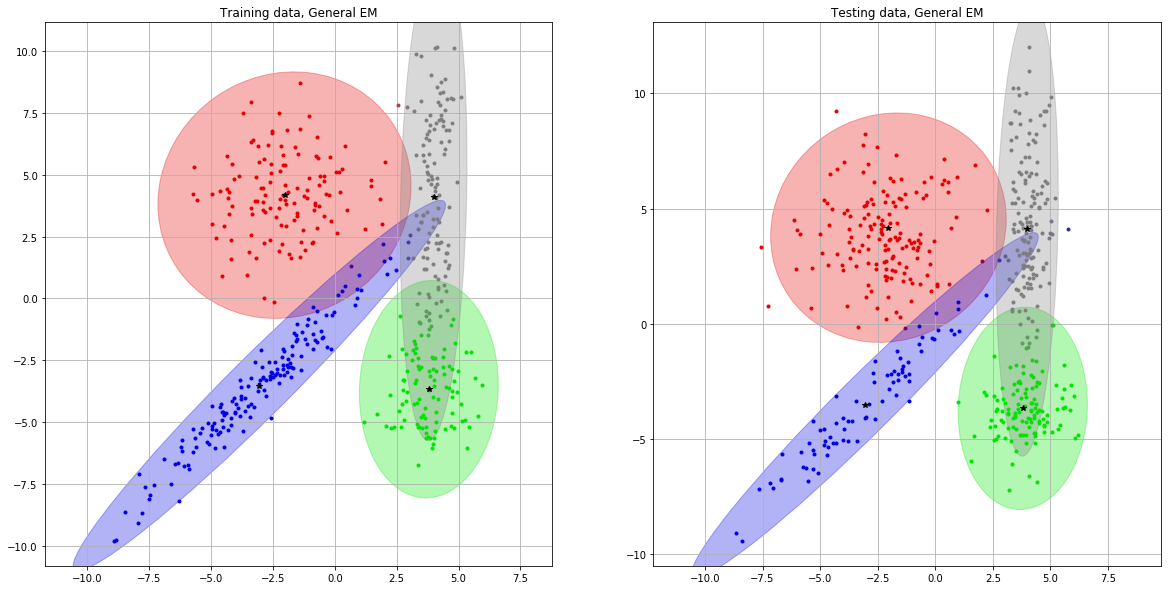

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
pi, mu, var, llc = em_train(data, K, vis="all", max_iter=50, isotropic=False)
plt.title("Training data, General EM")

plt.subplot(122)
Ytest = em_fit(test, pi, mu, var)
colors = np.array([(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.5, 0.5, 0.5)], dtype=float)
plot_em(test, pi, mu, var, colors)
plt.title("Testing data, General EM")
plt.show()

# III. Comparing all methods

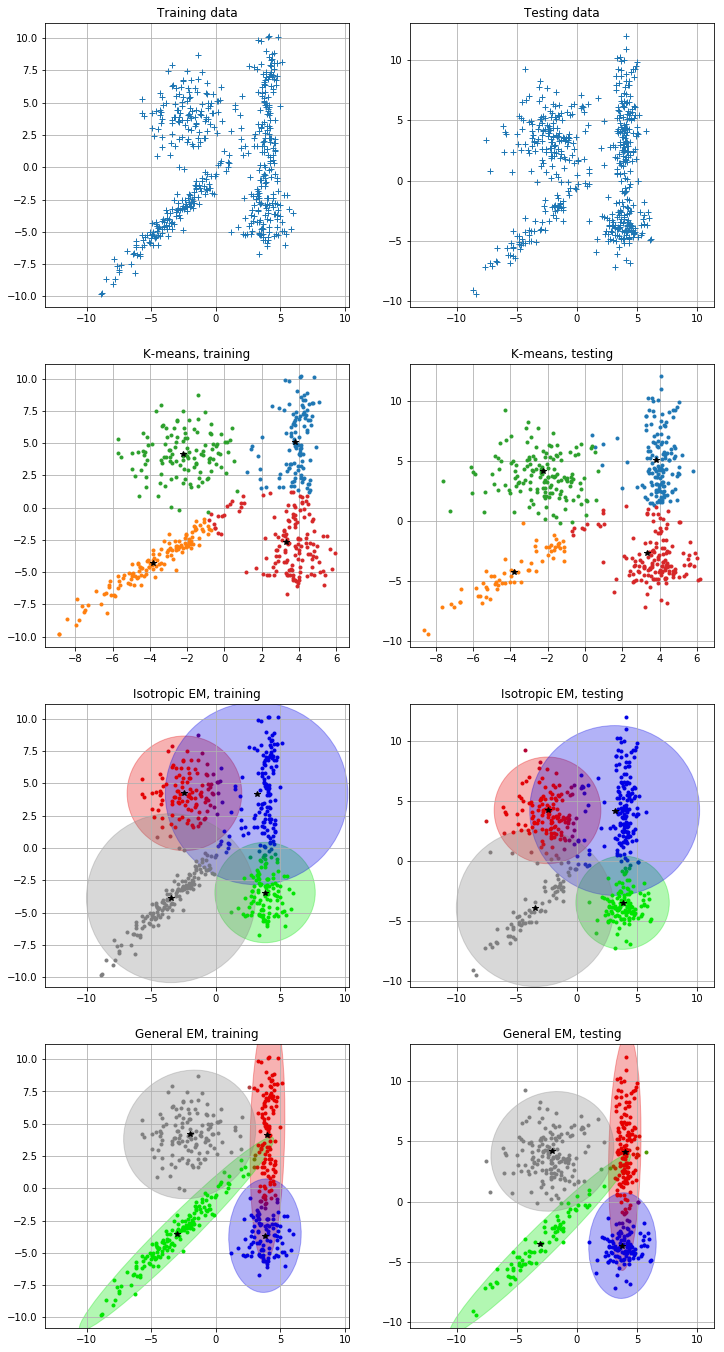

In [29]:
plt.figure(figsize=(12, 24))

# Original data
plt.subplot(421)
plt.grid()
plt.axis('equal')
plt.plot(data[:,0], data[:,1], "+")
plt.title("Training data")

plt.subplot(422)
plt.grid()
plt.axis('equal')
plt.plot(test[:,0], test[:,1], "+")
plt.title("Testing data")

# K-Means
plt.subplot(423)
Ykmeans, centroids = kmeans(data, K, vis="never", max_iter=20, plusplus=True)
plot_kmeans(data, Ykmeans, K, centroids)
plt.title("K-means, training")

plt.subplot(424)
Ykmeans = kmeans_fit(test, centroids)
plot_kmeans(test, Ykmeans, K, centroids)
plt.title("K-means, testing")

# Isotropic EM 
plt.subplot(425)
pi, mu, var, _ = em_train(data, K, vis="never", max_iter=50, isotropic=True)
llc_iso_train = complete_likelihood(data, pi, mu, var)
plot_em(data, pi, mu, var, colors)
plt.title("Isotropic EM, training")

plt.subplot(426)
Yem = em_fit(test, pi, mu, var)
llc_iso_test = complete_likelihood(test, pi, mu, var)
plot_em(test, pi, mu, var, colors)
plt.title("Isotropic EM, testing")

# General EM
plt.subplot(427)
pi, mu, var, llc = em_train(data, K, vis="never", max_iter=20)
llc_gen_train = complete_likelihood(data, pi, mu, var)
plot_em(data, pi, mu, var, colors)
plt.title("General EM, training")

plt.subplot(428)
Ytest = em_fit(test, pi, mu, var)
llc_gen_test = complete_likelihood(test, pi, mu, var)
colors = np.array([(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.5, 0.5, 0.5)], dtype=float)
plot_em(test, pi, mu, var, colors)
plt.title("General EM, testing")

plt.show()

## III. 2. Comparing log-likelihood

In [31]:
from IPython.display import HTML
content = f"""<table>
                <tr>
                    <th>Set</th>
                    <th>Isotropic</th>
                    <th>General</th>
                </tr>
                <tr>
                    <td>Train</td>
                    <td>{llc_iso_train:.2f}</td>
                    <td>{llc_gen_train:.2f}</td>
                </tr>
                <tr>
                    <td>Test</td>
                    <td>{llc_iso_test:.2f}</td>
                    <td>{llc_gen_test:.2f}</td>
                </tr>
            </table>"""

display(HTML(content))

Set,Isotropic,General
Train,-19740.56,-69820.00
Test,-19518.09,-66032.70
